# Galaxy Image Classification

Example of CNN classifier based in the dataset provided for the 'Galaxy Zoo' Kaggle competition

`https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/overview`

Some code snippets are taken from the submitted solutions.

In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split

from skimage import io
from skimage import color
from skimage.transform import resize

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Activation, Dropout
import tensorflow.keras.backend as K

2023-11-29 20:00:05.113816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('galaxy-zoo/training_solutions_rev1.csv')

df_train_and_validation, df_test = train_test_split(df, test_size=0.6)

df_train, df_val = train_test_split(df_train_and_validation, test_size=0.2)
df_train.shape, df_val.shape, df_test.shape

((19704, 38), (4927, 38), (36947, 38))

In [3]:
df_train

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
53399,878802,0.342000,0.658000,0.000000,0.658000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.526400,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
7356,208320,0.699239,0.176085,0.124676,0.000000,0.176085,0.000000,0.176085,0.000000,0.176085,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
3433,151641,0.510302,0.488494,0.001204,0.000000,0.488494,0.000000,0.488494,0.038465,0.450029,...,0.000000,0.038465,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.038465
53003,873049,0.203771,0.796229,0.000000,0.043871,0.752358,0.225119,0.527239,0.389992,0.362366,...,0.000000,0.214870,0.175122,0.000000,0.0,0.179981,0.000000,0.0,0.0,0.210011
28224,514158,0.468550,0.529737,0.001713,0.396173,0.133564,0.000000,0.133564,0.000000,0.133564,...,0.268969,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647,139523,0.861188,0.138812,0.000000,0.000000,0.138812,0.108301,0.030511,0.079916,0.058896,...,0.000000,0.000000,0.079916,0.000000,0.0,0.079916,0.000000,0.0,0.0,0.000000
4154,162153,0.358637,0.641363,0.000000,0.000000,0.641363,0.000000,0.641363,0.497952,0.143411,...,0.000000,0.202344,0.128486,0.167122,0.0,0.118299,0.000000,0.0,0.0,0.379653
8508,225337,0.611773,0.388227,0.000000,0.064834,0.323393,0.124187,0.199207,0.000000,0.323393,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
12245,280958,0.474214,0.522487,0.003299,0.297251,0.225236,0.075721,0.149515,0.055525,0.169711,...,0.093729,0.000000,0.000000,0.055525,0.0,0.055525,0.000000,0.0,0.0,0.000000


[392939 393141 244219 121875]


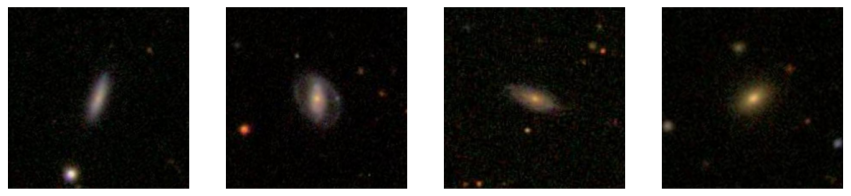

In [4]:
image_ids = np.random.choice(np.array(df_train['GalaxyID']), size=4)
print(image_ids)
image_paths = ['galaxy-zoo/images_training_rev1/'+str(im)+'.jpg' for im in image_ids]

# Load and display the images in a grid
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))

plt.subplots_adjust(hspace=0.1)

for ax, image_path in zip(axes.flat, image_paths):
    # Load the image using skimage.io.imread
    image = io.imread(image_path)
    
    # Resize the image for consistent display
    image = resize(image, (256, 256))
    
    # If the image has an alpha channel, remove it
    if image.shape[-1] == 4:
        image = color.rgba2rgb(image)
    
    ax.imshow(image)
    ax.axis('off')


In [5]:
len(df_train)

19704

In [6]:
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    return x

def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE, max_images=-1):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
  
    max = len(dataframe)
    if max_images>0:
        max = max_images
   
    sel = dataframe.values
    ids = sel[:max,0].astype(int).astype(str)
    
    y_batch = sel[:max,1:]
    x_batch = []
    for i in tqdm(ids):
        x = get_image('galaxy-zoo/images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch, y_batch

In [7]:
X_train, y_train = get_all_images(df_train, max_images=800)
X_val, y_val = get_all_images(df_val, max_images=200)

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 109.67it/s]


In [8]:
model = Sequential()

model.add(Conv2D(128, (3, 3), padding='same', name = 'conv2d_1', input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(256, (3, 3), padding='same', name = 'conv2d_2'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3), padding='same', name = 'conv2d_3'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Activation('relu'))
          
model.add(Flatten(name='flatten'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(37))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-11-29 20:00:18.936995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 256)      0

In [10]:
model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    batch_size=128
)

Epoch 1/30
7/7 [==============================] - 12s 2s/step - loss: 0.4417 - accuracy: 0.4125 - val_loss: 0.6900 - val_accuracy: 0.2950
Epoch 2/30
7/7 [==============================] - 11s 2s/step - loss: 0.3058 - accuracy: 0.5850 - val_loss: 0.6896 - val_accuracy: 0.2950
Epoch 3/30
7/7 [==============================] - 11s 2s/step - loss: 0.2887 - accuracy: 0.6150 - val_loss: 0.6879 - val_accuracy: 0.2950
Epoch 4/30
7/7 [==============================] - 11s 2s/step - loss: 0.2805 - accuracy: 0.6263 - val_loss: 0.6845 - val_accuracy: 0.2950
Epoch 5/30
7/7 [==============================] - 11s 2s/step - loss: 0.2768 - accuracy: 0.6250 - val_loss: 0.6779 - val_accuracy: 0.6000
Epoch 6/30
7/7 [==============================] - 11s 2s/step - loss: 0.2749 - accuracy: 0.6037 - val_loss: 0.6722 - val_accuracy: 0.6000
Epoch 7/30
7/7 [==============================] - 11s 2s/step - loss: 0.2709 - accuracy: 0.6275 - val_loss: 0.6634 - val_accuracy: 0.6000
Epoch 8/30
7/7 [==================

In [11]:
X_test, y_test = get_all_images(df_test, max_images=800)

100%|████████████████████████████████████████| 800/800 [00:07<00:00, 108.98it/s]


In [12]:
preds = model.predict(X_test)

25/25 [==============================] - 4s 142ms/step


In [13]:
class_preds = np.argmax(preds,axis=1)
class_values = np.argmax(y_test,axis=1)

In [14]:
success = class_preds-class_values

In [15]:
successrate = success.tolist().count(0)/len(y_test)
print('success on unseen data = ', successrate)

success on unseen data =  0.5875


In [35]:
x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2

filenames = os.listdir('galaxy-zoo/images_test_rev1/')
test_images = np.array([get_image('galaxy-zoo/images_test_rev1/'+file, x1,y1, shape=IMG_SHAPE, crop_size=CROP_SIZE) for file in filenames[:1000]])

In [36]:
preds = model.predict(test_images)

32/32 [==============================] - 5s 147ms/step


(array([2.1389e+04, 1.3000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0176e+04]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

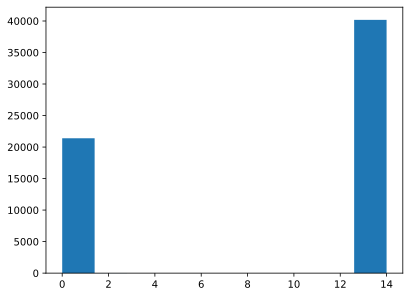

In [37]:
df.head(1)
res = np.argmax(df.values[:,1:],axis=1)
plt.hist(res)

In [23]:
np.argmax(preds, axis=1)

array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14])